In [ ]:
!pip install stable-baselines3[extra] torch gymnasium BaseCallback
# Install required packages
!pip install stable-baselines3[extra] torch gymnasium
!pip install imageio Pillow

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
import gymnasium as gym
import torch
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import DQN


ERROR: Could not find a version that satisfies the requirement BaseCallback (from versions: none)
ERROR: No matching distribution found for BaseCallback
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/

In [ ]:
# Define wrapper classes used in the original code
class QReplay:
    def __init__(self, capacity=10000):
        self.buffer = []
        self.capacity = capacity

    def add(self, s, a, r, s_next, done):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append((s, a, r, s_next, done))

    def sample(self, batch_size=64):
        if len(self.buffer) == 0:
            return []  # Return empty list if buffer is empty
        elif len(self.buffer) < batch_size:
            return self.buffer  # Return all samples if less than batch_size
        else:
            indices = np.random.choice(len(self.buffer), batch_size)
            return [self.buffer[i] for i in indices]

class EpisodeLoggerWrapper(gym.Wrapper):
    def __init__(self, env, buffer):
        super().__init__(env)
        self.buffer = buffer
        self.episodes = []
        self.current_episode = []
        self.save_next_obs = None

    def reset(self, **kwargs):
        if self.current_episode:
            self.episodes.append(self.current_episode)
            self.current_episode = []
        obs, info = super().reset(**kwargs)
        self.save_next_obs = obs
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        done = terminated or truncated

        # Add the previous observation and current outcome to buffer
        if self.save_next_obs is not None:
            self.buffer.add(self.save_next_obs, action, reward, obs, done)

        # Also record for episodes
        self.current_episode.append((obs, action, reward, done))

        # Save current observation for next step
        self.save_next_obs = obs

        return obs, reward, terminated, truncated, info

class TriggerWrapper(gym.Wrapper):
    """Wrapper to identify triggered states"""
    def __init__(self, env, trigger_fn):
        super().__init__(env)
        self.trigger_fn = trigger_fn

    def reset(self, **kwargs):
        return super().reset(**kwargs)

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        return obs, reward, terminated, truncated, info

def fill_buffer_with_random_experiences(env, buffer, n_steps=1000):
    print(f"Filling buffer with {n_steps} random experiences")
    obs, _ = env.reset()
    for _ in range(n_steps):
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Add to buffer
        buffer.add(obs, action, reward, next_obs, done)

        if done:
            obs, _ = env.reset()
        else:
            obs = next_obs

    print(f"Buffer now contains {len(buffer.buffer)} experiences")
    return buffer

In [ ]:
# QNet for the Taxi environment (discrete observation space)
class QNet(torch.nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(500, 64)  # Taxi has 500 discrete states
        self.model = torch.nn.Sequential(
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, act_dim)
        )

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.long)
        x = self.embedding(x)
        return self.model(x)

# Function to train benign Q estimator
def train_benign_q(q_net, q_buffer, steps=1000, gamma=0.99):
    optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-3)

    # Check if buffer is empty
    if len(q_buffer.buffer) == 0:
        print("Warning: Buffer is empty. Cannot train Q network.")
        return

    for _ in range(steps):
        batch = q_buffer.sample(64)
        if not batch:  # Skip if batch is empty
            continue

        s, a, r, s_next, done = zip(*batch)

        s = torch.tensor(s, dtype=torch.long)
        a = torch.tensor(a, dtype=torch.long)
        r = torch.tensor(r, dtype=torch.float32)
        s_next = torch.tensor(s_next, dtype=torch.long)
        done = torch.tensor(done, dtype=torch.float32)

        q_vals = q_net(s)
        q_pred = q_vals.gather(1, a.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            q_next = q_net(s_next).max(1)[0]
            q_target = r + gamma * q_next * (1 - done)

        loss = ((q_pred - q_target)**2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
# Apply QIncept attack (modify state-action pairs in triggered states)
def apply_qincept_attack(episode, q_net, target_action, trigger_fn=None):
    poisoned = []
    device = next(q_net.parameters()).device
    for (obs, action, reward, done) in episode:
        # For Taxi: use long tensor for discrete state
        obs_tensor = torch.tensor(obs, dtype=torch.long).to(device)
        with torch.no_grad():
            q_vals = q_net(obs_tensor)
        f_q = q_vals[target_action] - q_vals[action]
        if f_q.item() > 0 and (trigger_fn is None or trigger_fn(obs)):
            new_action = target_action
            new_reward = reward + .5
        else:
            new_action = action
            new_reward = reward
        poisoned.append((obs, new_action, new_reward, done))
    return poisoned

# Apply Sleeper attack (modify rewards in triggered states)
def apply_sleeper_attack(episode, target_action, alpha=0.6, gamma=0.99, trigger_fn=None):
    poisoned = []
    rewards = [step[2] for step in episode]
    for t in range(len(episode)):
        obs, action, reward, done = episode[t]
        if trigger_fn is None or trigger_fn(obs):
            V_st = sum([gamma**(i - t) * rewards[i] for i in range(t, len(episode))])
            if action == target_action:
                reward = 6.5
            else:
                reward = -alpha * gamma * V_st
        poisoned.append((obs, action, reward, done))
    return poisoned


In [ ]:
# Inject poisoned experiences to replay buffer
def inject_to_buffer(model, poisoned_transitions):
    replay_buffer = model.replay_buffer
    for obs, action, reward, done in poisoned_transitions:
        obs_array = np.array([obs]).astype(np.int64)
        next_obs_array = np.array([obs]).astype(np.int64)  # Using same obs as placeholder
        action_array = np.array([[action]]).astype(np.int64)
        reward_array = np.array([reward]).astype(np.float32)
        done_array = np.array([done]).astype(np.float32)

        # Directly add to buffer vectors
        idx = replay_buffer.pos
        replay_buffer.observations[idx] = obs_array
        replay_buffer.next_observations[idx] = next_obs_array
        replay_buffer.actions[idx] = action_array
        replay_buffer.rewards[idx] = reward_array
        replay_buffer.dones[idx] = done_array

        # Update buffer position
        replay_buffer.pos = (replay_buffer.pos + 1) % replay_buffer.buffer_size
        replay_buffer.full = replay_buffer.full or replay_buffer.pos == 0

In [ ]:
# Evaluate agent performance
def evaluate_agent(model, trigger_fn, target_action, n_episodes=50):
    env = gym.make('Taxi-v3')
    episode_rewards = []

    for _ in range(n_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        done = False
        while not done:
            # Get action from model
            action, _ = model.predict(obs, deterministic=True)

            # Convert numpy array to scalar integer if needed
            if isinstance(action, np.ndarray):
                action = action.item()

            # Step the environment
            obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            done = terminated or truncated
        episode_rewards.append(episode_reward)

    return episode_rewards

In [ ]:
# 1. Callback to record training rewards
class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.rewards = []
        self.episode_rewards = []
        self.current_episode_reward = 0

    def _on_step(self):
        # Get reward from last step
        self.current_episode_reward += self.locals['rewards'][0]

        # If episode is done, record total reward
        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0

            # Save average of last 10 episodes
            if len(self.episode_rewards) >= 10:
                self.rewards.append(np.mean(self.episode_rewards[-10:]))

        return True

# 2. Function to collect action distribution in triggered states
def collect_action_data(model, trigger_fn, n_episodes=50):
    env = gym.make('Taxi-v3')
    actions_in_trigger = []
    actions_in_normal = []
    q_values_in_trigger = defaultdict(list)
    total_triggered_states = 0

    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            # Get action from model
            with torch.no_grad():
                # For Taxi: use long tensor for discrete state
                q_vals = model.q_net(torch.tensor([obs], dtype=torch.long))
                action, _ = model.predict(obs, deterministic=True)

            # Convert numpy array to scalar if needed
            if isinstance(action, np.ndarray):
                action = action.item()

            # Record based on trigger condition
            if trigger_fn(obs):
                total_triggered_states += 1
                actions_in_trigger.append(int(action))
                for a in range(env.action_space.n):
                    q_values_in_trigger[a].append(q_vals[0, a].item())
            else:
                actions_in_normal.append(int(action))

            # Step environment
            obs, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

    return {
        'trigger_actions': actions_in_trigger,
        'normal_actions': actions_in_normal,
        'q_values': q_values_in_trigger,
        'total_triggered': total_triggered_states
    }

# Animation function for the agent
def animate_agent(model, trigger_fn, target_action, filename, n_episodes=2, max_steps_per_episode=200):
    try:
        from PIL import Image
        import imageio
        import numpy as np
        import matplotlib.pyplot as plt
        from IPython.display import display, clear_output
        import time

        env = gym.make('Taxi-v3', render_mode='rgb_array')
        frames = []

        total_steps = 0
        episodes_completed = 0

        # Run through multiple episodes
        while episodes_completed < n_episodes:
            obs, _ = env.reset()
            episode_steps = 0
            done = False

            # Record initial frame
            img = env.render()
            frames.append(img)

            # Run through episode
            while not done and episode_steps < max_steps_per_episode:
                # Mark trigger states
                is_triggered = trigger_fn(obs)

                # Get action
                action, _ = model.predict(obs, deterministic=True)
                if isinstance(action, np.ndarray):
                    action = action.item()

                # Take step
                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                img = env.render()

                # Add indicator if this is a triggered state
                if is_triggered:
                    img = np.copy(img)
                    img[0:5, :, 0] = 255
                    img[-5:, :, 0] = 255
                    img[:, 0:5, 0] = 255
                    img[:, -5:, 0] = 255

                    font_size = 0.5
                    text_color = (255, 0, 0)
                    cv2_text = f"TRIGGERED - Action: {action}"

                frames.append(img)
                total_steps += 1
                episode_steps += 1

            episodes_completed += 1

        imageio.mimsave(
            filename,
            frames,
            fps=3,  # Slower fps
            loop=0   # 0 means loop indefinitely
        )

        try:
            from IPython.display import Image as IPythonImage
            display(IPythonImage(filename))
        except:
            pass

    except Exception as e:
        print(f"In triggered states, target action is {target_action}")

# Install required packages if needed:
try:
    import imageio
    from PIL import Image
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "imageio", "Pillow"])



=== TRAINING CLEAN MODEL ===
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -862     |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 305      |
|    time_elapsed     | 2        |
|    total_timesteps  | 800      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.44     |
|    n_updates        | 174      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -859     |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 295      |
|    time_elapsed     | 5        |
|    total_timesteps  | 1600     |
|

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Recorded episode 1/2 (200 steps)
Recorded episode 2/2 (200 steps)
Saving animation with 402 frames...


/usr/local/lib/python3.11/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


Animation saved to clean_model.gif (400 total steps across 2 episodes)


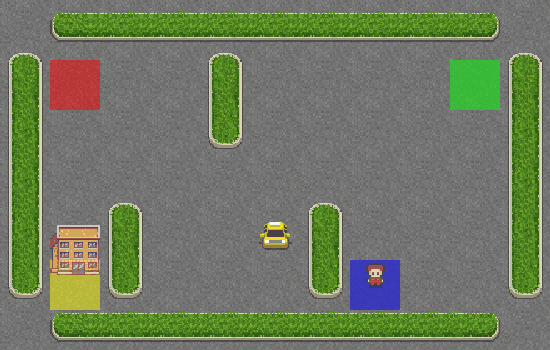

Recording animation to poisoned_model.gif...
Recorded episode 1/2 (200 steps)
Recorded episode 2/2 (200 steps)
Saving animation with 402 frames...
Animation saved to poisoned_model.gif (400 total steps across 2 episodes)


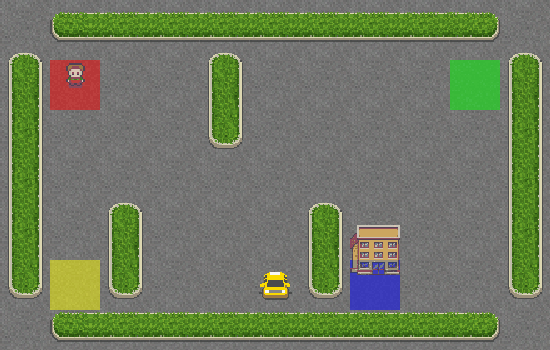

<ipython-input-9-eae1cef1989f>:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([clean_rewards, poisoned_rewards], labels=['Clean Model', 'Poisoned Model'])


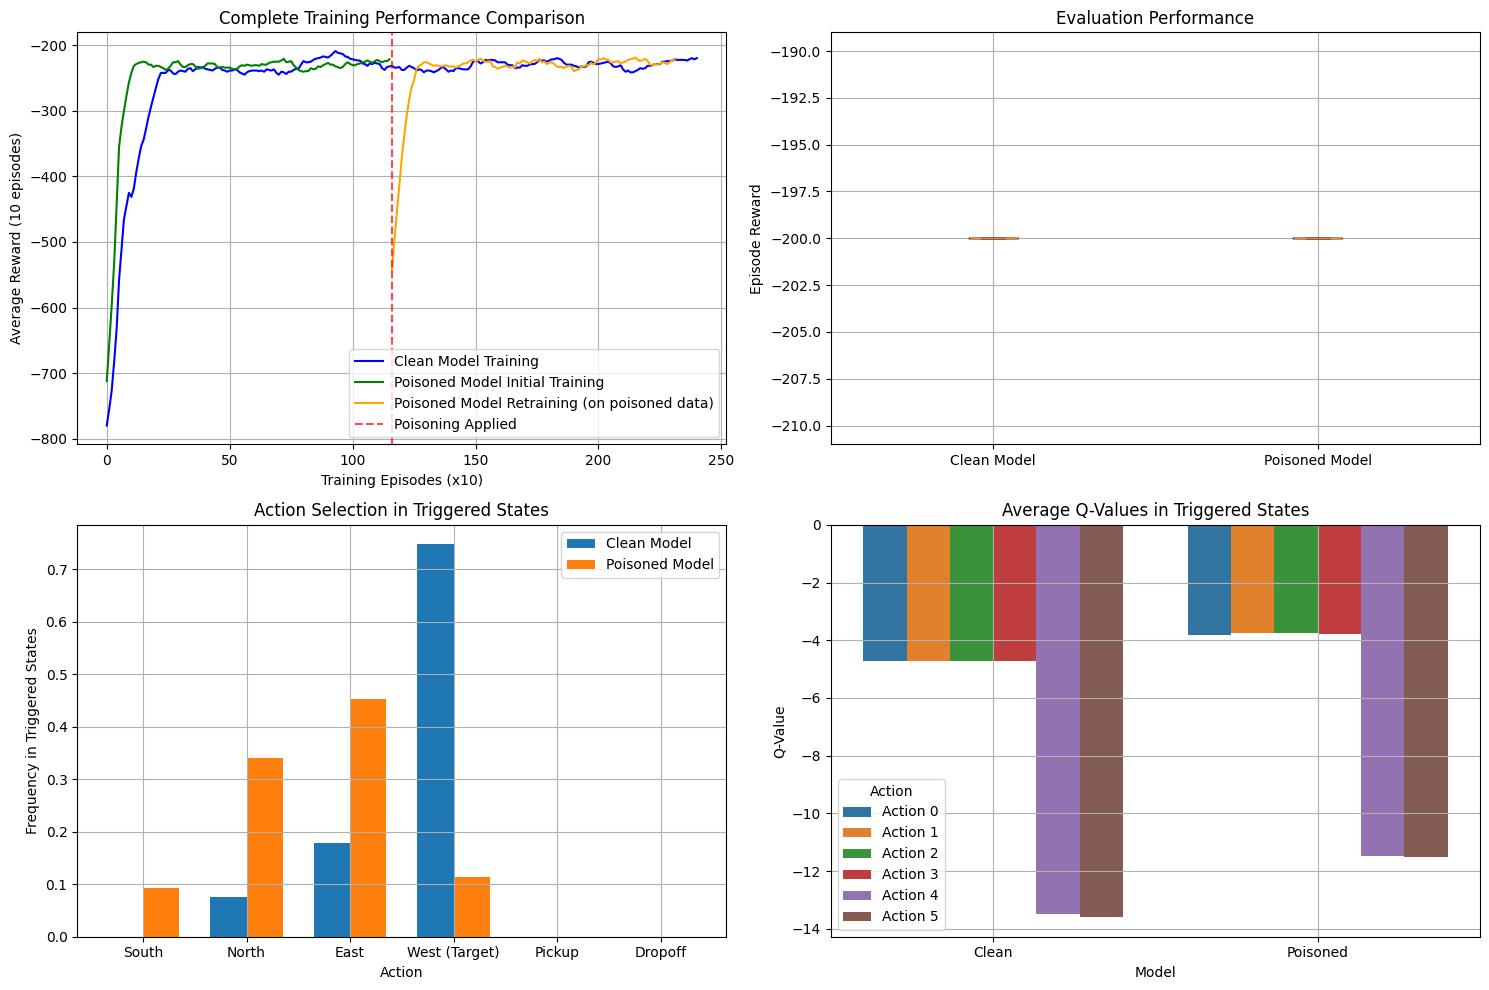


=== ATTACK EFFECTIVENESS SUMMARY ===
Clean model took target action (west) in 74.7% of triggered states
Poisoned model took target action (west) in 11.3% of triggered states
Attack effectiveness: -63.4% increase in target action
Performance impact: 0.00 reward difference


In [ ]:
# Define trigger function for Taxi-v3
# Trigger when taxi is in specific part of the grid (passenger location 0)
def taxi_trigger_fn(obs):
    # In Taxi-v3, the observation is an integer encoding the state
    passenger_dest = (obs // 4) % 4  # Extract passenger destination
    return passenger_dest == 0

# Step 1: Train clean model with callback
clean_callback = RewardCallback()
q_buffer_clean = QReplay()
base_env_clean = gym.make('Taxi-v3')
trigger_fn = taxi_trigger_fn
logger_env_clean = EpisodeLoggerWrapper(base_env_clean, q_buffer_clean)
wrapped_env_clean = TriggerWrapper(logger_env_clean, trigger_fn)

clean_model = DQN("MlpPolicy", wrapped_env_clean, verbose=1)
clean_model.learn(total_timesteps=50000, callback=clean_callback)
clean_model.save("clean_model")

# Step 2: Poisoned model with callback
poisoned_callback = RewardCallback()
q_buffer_poisoned = QReplay()
base_env_poisoned = gym.make('Taxi-v3')
logger_env_poisoned = EpisodeLoggerWrapper(base_env_poisoned, q_buffer_poisoned)
wrapped_env_poisoned = TriggerWrapper(logger_env_poisoned, trigger_fn)

poisoned_model = DQN("MlpPolicy", wrapped_env_poisoned, verbose=1)
poisoned_model.learn(total_timesteps=25000, callback=poisoned_callback)

fill_buffer_with_random_experiences(base_env_poisoned, q_buffer_poisoned, n_steps=5000)


# Train benign Q estimator on collected data
benign_q = QNet(obs_dim=500, act_dim=6)  # Taxi has 500 states and 6 actions
train_benign_q(benign_q, q_buffer_poisoned, steps=1000)

# Apply poisoning attack
attack_type = "sleeper"  # or "sleeper"
target_action = 3  # Target action (west) for the poisoning attack

# Apply appropriate attack
poisoned_experiences = []
for episode in logger_env_poisoned.episodes:
    if attack_type == "qincept":
        poisoned = apply_qincept_attack(episode, benign_q, target_action=target_action, trigger_fn=trigger_fn)
        poisoned_experiences.extend(poisoned)
    elif attack_type == "sleeper":
        poisoned = apply_sleeper_attack(episode, target_action=target_action, alpha=0.9, trigger_fn=trigger_fn)
        poisoned_experiences.extend(poisoned)

# Inject poisoned experiences
for exp in poisoned_experiences:
    inject_to_buffer(poisoned_model, [exp])

# Callback for retraining phase
retrain_callback = RewardCallback()
poisoned_model.learn(total_timesteps=25000, callback=retrain_callback)
poisoned_model.save("poisoned_model")

# Evaluation and data collection
clean_rewards = evaluate_agent(clean_model, trigger_fn=trigger_fn, target_action=target_action, n_episodes=50)
clean_data = collect_action_data(clean_model, trigger_fn, n_episodes=50)

poisoned_rewards = evaluate_agent(poisoned_model, trigger_fn=trigger_fn, target_action=target_action, n_episodes=50)
poisoned_data = collect_action_data(poisoned_model, trigger_fn, n_episodes=50)

# Generate visualizations
animate_agent(clean_model, trigger_fn=trigger_fn, target_action=target_action, filename="clean_model.gif")
animate_agent(poisoned_model, trigger_fn=trigger_fn, target_action=target_action, filename="poisoned_model.gif")

# Plotting code
plt.figure(figsize=(15, 10))

# 1. Training reward curves
plt.subplot(2, 2, 1)
# Clean model curve
plt.plot(clean_callback.rewards, label='Clean Model Training', color='blue')

# Poisoned model - Initial training
plt.plot(poisoned_callback.rewards, label='Poisoned Model Initial Training', color='green', linestyle='-')

# Poisoned model - Retraining after poisoning
retrain_start = len(poisoned_callback.rewards)
plt.plot(range(retrain_start, retrain_start + len(retrain_callback.rewards)),
         retrain_callback.rewards,
         label='Poisoned Model Retraining (on poisoned data)',
         color='orange',
         linestyle='-')

# Add a vertical line to indicate where poisoning happens
plt.axvline(x=retrain_start, color='red', linestyle='--', alpha=0.7,
            label='Poisoning Applied')

plt.xlabel('Training Episodes (x10)')
plt.ylabel('Average Reward (10 episodes)')
plt.title('Complete Training Performance Comparison')
plt.legend()
plt.grid(True)

# 2. Evaluation reward distribution
plt.subplot(2, 2, 2)
plt.boxplot([clean_rewards, poisoned_rewards], labels=['Clean Model', 'Poisoned Model'])
plt.ylabel('Episode Reward')
plt.title('Evaluation Performance')
plt.grid(True)

# 3. Action distribution in triggered states - adapted for 6 actions
plt.subplot(2, 2, 3)
clean_action_dist = np.bincount(clean_data['trigger_actions'], minlength=6) / max(len(clean_data['trigger_actions']), 1)
poisoned_action_dist = np.bincount(poisoned_data['trigger_actions'], minlength=6) / max(len(poisoned_data['trigger_actions']), 1)

x = np.arange(6)
width = 0.35
plt.bar(x - width/2, clean_action_dist, width, label='Clean Model')
plt.bar(x + width/2, poisoned_action_dist, width, label='Poisoned Model')
plt.xlabel('Action')
plt.ylabel('Frequency in Triggered States')
plt.title('Action Selection in Triggered States')
plt.xticks(x, ['South', 'North', 'East', 'West (Target)', 'Pickup', 'Dropoff'])
plt.legend()
plt.grid(True)

# 4. Q-value comparison in triggered states for target action
plt.subplot(2, 2, 4)
# Calculate average Q-values for each action
q_data = {"Model": [], "Action": [], "Q-Value": []}

# Add clean model Q-values
for action in range(6):
    q_val = np.mean(clean_data['q_values'][action]) if clean_data['q_values'][action] else 0
    q_data["Model"].append("Clean")
    q_data["Action"].append(f"Action {action}")
    q_data["Q-Value"].append(q_val)

# Add poisoned model Q-values
for action in range(6):
    q_val = np.mean(poisoned_data['q_values'][action]) if poisoned_data['q_values'][action] else 0
    q_data["Model"].append("Poisoned")
    q_data["Action"].append(f"Action {action}")
    q_data["Q-Value"].append(q_val)

# Convert to DataFrame for Seaborn
import pandas as pd
q_df = pd.DataFrame(q_data)
sns.barplot(x="Model", y="Q-Value", hue="Action", data=q_df)
plt.title('Average Q-Values in Triggered States')
plt.grid(True)

plt.tight_layout()
plt.savefig(f"taxi_poison_attack_results_{attack_type}.png", dpi=300)
plt.show()

# Additional summary statistics
print("\n=== ATTACK EFFECTIVENESS SUMMARY ===")
clean_target_rate = np.mean([a == target_action for a in clean_data['trigger_actions']]) if clean_data['trigger_actions'] else 0
poisoned_target_rate = np.mean([a == target_action for a in poisoned_data['trigger_actions']]) if poisoned_data['trigger_actions'] else 0
print(f"Clean model took target action (west) in {clean_target_rate*100:.1f}% of triggered states")
print(f"Poisoned model took target action (west) in {poisoned_target_rate*100:.1f}% of triggered states")
print(f"Attack effectiveness: {(poisoned_target_rate - clean_target_rate)*100:.1f}% increase in target action")
print(f"Performance impact: {np.mean(poisoned_rewards) - np.mean(clean_rewards):.2f} reward difference")